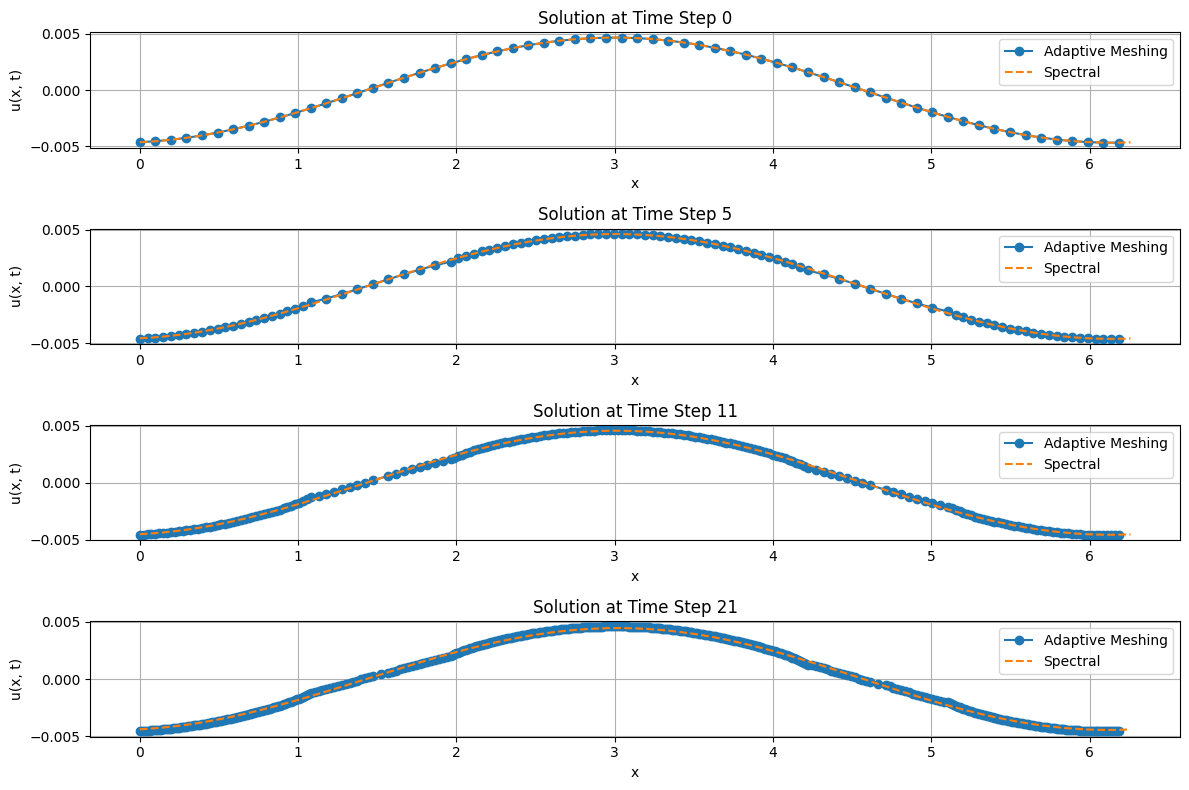

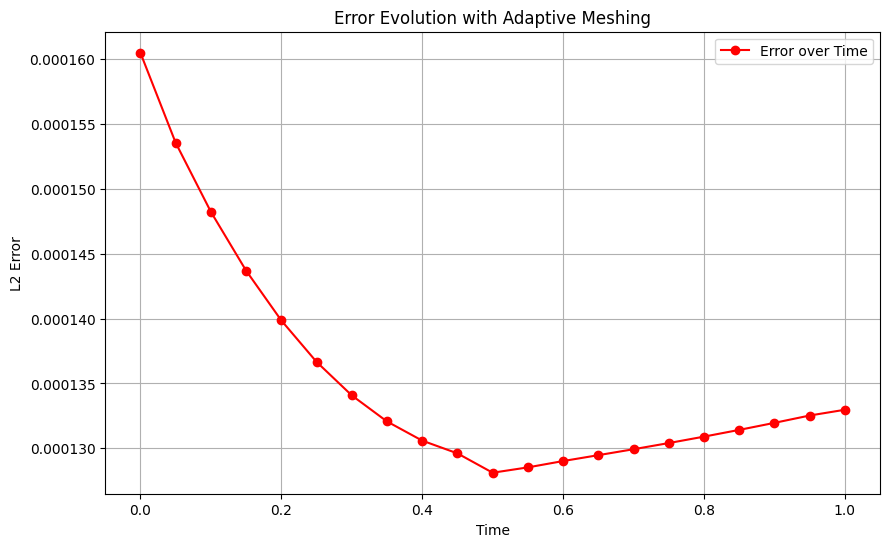

Final L2 Error: 0.0001329731044187285


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from tqdm import tqdm

# FUNCTIONS SECTION

def compute_error(x_ref, u_ref, x_coarse, u_coarse):
    """Compute error using interpolation."""
    interpolant = PchipInterpolator(x_coarse, u_coarse, extrapolate=True)
    u_coarse_interp = interpolant(x_ref)
    error = np.sqrt(np.mean((u_ref - u_coarse_interp) ** 2))
    return error

def initialize_fourier_modes(Q, option, x, M):
    beta = np.zeros(M)
    gamma = np.zeros(M)

    if option == 'uniform':
        beta = np.random.rand(M) * (-Q) ** np.arange(1, M + 1)
        gamma = np.random.rand(M) * (-Q) ** np.arange(1, M + 1)
    elif option == 'gaussian_1':
        beta = np.random.randn(M) * Q ** np.arange(1, M + 1)
        gamma = np.random.randn(M) * Q ** np.arange(1, M + 1)
    elif option == 'gaussian_2':
        beta = np.random.randn(M) * (Q / (np.arange(1, M + 1) ** 2))
        gamma = np.random.randn(M) * (Q / (np.arange(1, M + 1) ** 2))
    else:
        raise ValueError("Unknown initialization option.")

    alpha = (beta + 1j * gamma) * np.exp(-0.1 * np.arange(1, M + 1))  # Apply exponential damping
    u_init = np.zeros_like(x, dtype=np.complex128)

    for l in range(M):
        u_init += alpha[l] * np.exp(1j * (l + 1) * x)

    return np.real(u_init)

def finite_difference_update(u, dx, dt, nu):
    N = len(u)
    u_next = np.zeros_like(u)

    for i in range(N):
        i_plus = (i + 1) % N
        i_minus = (i - 1) % N
        adv = u[i] * (u[i_plus] - u[i_minus]) / (2 * dx)
        diff = nu * (u[i_plus] - 2 * u[i] + u[i_minus]) / dx**2
        u_next[i] = u[i] - dt * adv + dt * diff

    return u_next

def adaptive_meshing(u, x, dx, threshold):
    N = len(x)
    refined_x = []
    refined_u = []

    for i in range(N):
        i_plus = (i + 1) % N
        i_minus = (i - 1) % N
        second_derivative = (u[i_plus] - 2 * u[i] + u[i_minus]) / dx**2

        refined_x.append(x[i])
        refined_u.append(u[i])

        if abs(second_derivative) > threshold and i < N - 1:
            midpoint_x = 0.5 * (x[i] + x[i_plus])
            midpoint_u = 0.5 * (u[i] + u[i_plus])
            refined_x.append(midpoint_x)
            refined_u.append(midpoint_u)

    return np.array(refined_x), np.array(refined_u)

def solve_burgers_adaptive(Q, option, nu, L, N, M, T, threshold, u_init_ref, x_ref):
    x = np.linspace(0, L, N, endpoint=False)
    dx = x[1] - x[0]
    dt = min(0.5 * dx / max(1, 0.1), 0.1 * dx**2 / nu)

    # Interpolate initial condition from high-resolution grid
    interpolant = PchipInterpolator(x_ref, u_init_ref, extrapolate=True)
    u = interpolant(x)

    u_history = [u]
    x_history = [x]
    time_steps = int(T / dt)

    error_history = []

    for step_counter in range(time_steps):
        u = finite_difference_update(u, dx, dt, nu)

        if step_counter % 50 == 0:
            x_new, u_new = adaptive_meshing(u.copy(), x.copy(), dx.copy(), threshold)
            x, u = x_new.copy(), u_new.copy()
            dx_new = x[1] - x[0]
            dt_new = min(0.5 * dx_new / max(abs(u)), 0.1 * dx_new**2 / nu)
            dx, dt = dx_new.copy(), dt_new.copy()

        if step_counter % max(1, time_steps // 20) == 0:
            x_history.append(x.copy())
            u_history.append(u.copy())

            # Compute error against final spectral solution at this step
            '''
              If spectral solution ran for 100 time steps, then u_refined_history[- 1] is basically u_refined_history[99]
              i.e. the finalmost solution we got from spectral method which we deemed to be the GOLD solution
              Now while running adaptive meshing, at every step when we want to evalute the performance/error,
              we check the current u_adaptive with the perfect u_refined which is u_refined_history[99].
            '''
            if len(u_history) <= len(u_refined_history):
                error = compute_error(x_refined, u_refined_history[- 1], x, u)

                # error = compute_error(x_refined, u_refined_history[len(u_history) - 1], x, u)
                error_history.append(error)

    return x_history, u_history, error_history

def spectral_burgers_update(u_hat, k, dt, nu):
    u = np.real(np.fft.ifft(u_hat))  # Transform to physical space
    nonlinear_term = -0.5j * k * np.fft.fft(u**2)  # Nonlinear term in Fourier space
    #u_hat_next = (u_hat + dt * nonlinear_term) / (1 + nu * dt * k**2)  # Update with diffusion
    u_hat_next = (u_hat + dt * (nonlinear_term - nu*k**2*u_hat)) # Update with diffusion
    return u_hat_next

def compute_spectral_refined(Q, nu, L, T, N_ref, u_init_ref):
    x_ref = np.linspace(0, L, N_ref, endpoint=False)
    dx_ref = x_ref[1] - x_ref[0]
    dt_ref = min(0.1 * dx_ref**2 / (2 * nu), 0.1 * dx_ref / 1.0)
    k_ref = (2 * np.pi / L) * np.concatenate((np.arange(0, N_ref // 2), np.arange(-N_ref // 2, 0)))

    u_ref = u_init_ref.copy()
    u_hat = np.fft.fft(u_ref)
    u_history = [u_ref]
    time_steps = int(T / dt_ref)

    for step_counter in range(time_steps):
        u_hat = spectral_burgers_update(u_hat, k_ref, dt_ref, nu)
        if step_counter % max(1, time_steps // 20) == 0:
            u_history.append(np.real(np.fft.ifft(u_hat)))

    return x_ref, u_history

def compute_second_derivative(u, x):
    N = len(x)
    second_derivative = np.zeros_like(u)
    dx = x[1] - x[0]

    for i in range(N):
        i_plus = (i + 1) % N
        i_minus = (i - 1) % N
        second_derivative[i] = (u[i_plus] - 2 * u[i] + u[i_minus]) / dx**2

    return second_derivative

def compute_error_and_gradient(Q, nu, L, N, M, T, threshold, plot=False):
    # Solve Burgers' equation with adaptive meshing
    x_history, u_history, error_history = solve_burgers_adaptive(Q, 'uniform', nu, L, N, M, T, threshold, u_init_ref, x_ref)

    # Compute refined solution using spectral method
    x_refined, u_refined_history = compute_spectral_refined(Q, nu, L, T, 256, u_init_ref)  # Higher resolution

    # Compute errors and gradients
    errors = []
    gradients = []
    num_steps = min(len(u_refined_history), len(u_history))  # Ensure same length
    for i in range(num_steps):
        # Compute error & gradient for each time step
        error = compute_error(x_refined, u_refined_history[i], x_history[i], u_history[i])
        errors.append(error)
        gradients.append(compute_second_derivative(u_history[i], x_history[i]))

    # Plot the error evolution
    if plot:
        num_points = len(errors)
        time_points = np.linspace(0, T, num_points)
        plt.figure(figsize=(10, 6))
        plt.plot(time_points, errors, label='Spectral Interpolation', linewidth=2, color='blue', marker='o')
        plt.xlabel('Time', fontsize=14)
        plt.ylabel('L2 Error', fontsize=14)
        plt.title('Error Evolution with Spectral Interpolation', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

    return gradients[-1], errors[-1]



# Constants and parameters
nu = 0.01  # Viscosity
L = 2 * np.pi  # Domain length
N = 64  # Initial coarse number of spatial grid points
T = 5  # Total simulation time
M = 20  # Number of Fourier modes
threshold = 0.002  # Lower threshold for more aggressive mesh refinement
Q = 0.01  # Amplitude of the initial condition

# High-resolution grid for consistent initialization
N_ref = 256
x_ref = np.linspace(0, L, N_ref, endpoint=False)
u_init_ref = initialize_fourier_modes(Q, 'uniform', x_ref, M)

'''
Make sure the spectral refined is called first and then the adaptive meshing
'''

# Solve Burgers' equation using spectral method
x_refined, u_refined_history = compute_spectral_refined(Q, nu, L, T, N_ref, u_init_ref)

# Solve Burgers' equation with adaptive meshing
x_history, u_history, error_history = solve_burgers_adaptive(Q, 'uniform', nu, L, N, M, T, threshold, u_init_ref, x_ref)

# Plot the solution at different time steps
time_steps_to_plot = [0, len(u_history) // 4, len(u_history) // 2, len(u_history) - 1]
plt.figure(figsize=(12, 8))

for i, step in enumerate(time_steps_to_plot):
    plt.subplot(len(time_steps_to_plot), 1, i + 1)
    plt.plot(x_history[step], u_history[step], label='Adaptive Meshing', marker='o')
    plt.plot(x_refined, u_refined_history[step], label='Spectral', linestyle='--')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.title(f'Solution at Time Step {step}')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

# Plot error over time
plt.figure(figsize=(10, 6))
# plt.plot(np.linspace(0, T, len(error_history)), error_history, label='Error over Time', color='red', marker='o')
plt.plot(np.linspace(0, 1, len(error_history)), error_history, label='Error over Time', color='red', marker='o')
plt.xlabel('Time')
plt.ylabel('L2 Error')
plt.title('Error Evolution with Adaptive Meshing')
plt.legend()
plt.grid()
plt.show()


final_error = compute_error(x_refined, u_refined_history[-1], x_history[-1], u_history[-1])
print(f"Final L2 Error: {final_error}")

In [3]:
def generate_training_data(Q, nu, L, N, M, T, threshold, num_samples, max_len):

    training_data = []
    labels = []

    for _ in tqdm(range(num_samples), desc="Generating Training Data"):
        # Solve Burgers' equation with adaptive meshing
        x_history, u_history, _ = solve_burgers_adaptive(Q, 'uniform', nu, L, N, M, T, threshold, u_init_ref, x_ref)

        for i in range(len(u_history) - 1):  # Loop through each time step except the last
            # Compute second derivative
            second_derivative = compute_second_derivative(u_history[i], x_history[i])

            # Binary classification for refinement points
            refine_points = (np.abs(second_derivative) > threshold).astype(float)

            # Pad x, u, and refinement points to fixed length
            padded_x = np.pad(x_history[i], (0, max(0, max_len - len(x_history[i]))), mode='constant')[:max_len]
            padded_u = np.pad(u_history[i], (0, max(0, max_len - len(u_history[i]))), mode='constant')[:max_len]
            padded_refine = np.pad(refine_points, (0, max(0, max_len - len(refine_points))), mode='constant')[:max_len]

            # Store the data
            training_data.append(np.stack((padded_x, padded_u), axis=1))
            labels.append(padded_refine)

    return np.array(training_data), np.array(labels)

# Parameters for data generation
num_samples = 1000  # Number of training samples
max_len = 256      # Fixed maximum length for padding

# Generate training data
training_data, training_labels = generate_training_data(Q, nu, L, N, M, T, threshold, num_samples, max_len)

# Inspect the generated data
print(f"Training data shape: {training_data.shape}")
print(f"Training labels shape: {training_labels.shape}")


Generating Training Data: 100%|██████████| 1000/1000 [01:03<00:00, 15.66it/s]


Training data shape: (21000, 256, 2)
Training labels shape: (21000, 256)


In [5]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling1D
import matplotlib.pyplot as plt
import numpy as np

# Compute class weights for imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(training_labels.flatten()),
    y=training_labels.flatten()
)
class_weights = dict(enumerate(class_weights))

# Build the CNN model for adaptive meshing
def build_adaptive_mesh_cnn(input_shape):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(input_shape[0], activation='sigmoid')(x)  # Binary refinement prediction

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and train the model
input_shape = training_data.shape[1:]
adaptive_mesh_model = build_adaptive_mesh_cnn(input_shape)

# Train the model with class weights
history = adaptive_mesh_model.fit(
    training_data, training_labels,
    epochs=20, batch_size=32,
    validation_split=0.2,
    class_weight=class_weights
)

# Evaluate the model: Actual vs Predicted Refinement Points
actual_outputs = []
predicted_outputs = []

for sample_idx in range(50):  # Subset of test data for visualization
    x_sample = training_data[sample_idx, :, 0]
    u_sample = training_data[sample_idx, :, 1]
    true_refinement = training_labels[sample_idx]

    # Predict refinement probabilities
    input_data = np.expand_dims(training_data[sample_idx], axis=0)
    predicted_refinement = adaptive_mesh_model.predict(input_data, verbose=0).squeeze()

    actual_outputs.extend(true_refinement)
    predicted_outputs.extend(predicted_refinement)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actual_outputs, predicted_outputs))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# # Plot Actual vs Predicted Refinement Probabilities
# plt.figure(figsize=(10, 6))
# plt.scatter(actual_outputs, predicted_outputs, alpha=0.5, edgecolor='k')
# plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
# plt.xlabel('Actual Refinement Probability')
# plt.ylabel('Predicted Refinement Probability')
# plt.title('Actual vs Predicted Refinement Probabilities')
# plt.legend()
# plt.grid()
# plt.show()


Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.0030 - loss: 0.2987 - val_accuracy: 0.0000e+00 - val_loss: 0.1103
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.0014 - loss: 0.1244 - val_accuracy: 0.0000e+00 - val_loss: 0.0952
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.0013 - loss: 0.1166 - val_accuracy: 0.0000e+00 - val_loss: 0.0992
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 9.1529e-04 - loss: 0.1124 - val_accuracy: 0.0000e+00 - val_loss: 0.0945
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 6.3741e-04 - loss: 0.1130 - val_accuracy: 0.0000e+00 - val_loss: 0.0946
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 7.3912e-04 - loss: 0.1113 - val_accuracy: 0.0000e+00 - val_loss: 0.0948
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.0017 - loss: 0.1078 - val_accuracy: 0.0000e+00 - val_loss: 0.1002
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/s

In [6]:
def solve_burgers_with_nn(Q, option, nu, L, N, M, T, adaptive_mesh_model, max_len, u_init_ref, x_ref):

    x = np.linspace(0, L, N, endpoint=False)
    dx = x[1] - x[0]
    dt = min(0.5 * dx / max(1, 0.1), 0.1 * dx**2 / nu)

    # Interpolate initial condition from high-resolution grid
    interpolant = PchipInterpolator(x_ref, u_init_ref, extrapolate=True)
    u = interpolant(x)

    x_history = [x.copy()]
    u_history = [u.copy()]
    time_steps = int(T / dt)

    for step in tqdm(range(time_steps), desc="Solving Burgers' equation with NN adaptive meshing"):
        # Update u using finite difference
        u = finite_difference_update(u, dx, dt, nu)

        # Perform adaptive meshing every few steps
        if step % 50 == 0:
            # Prepare input for the NN model
            u_norm = (u - np.min(u)) / (np.max(u) - np.min(u) + 1e-8)
            x_norm = (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-8)
            input_data = np.stack((u_norm, x_norm), axis=-1)  # Shape (N, 2)
            input_data = np.expand_dims(input_data, axis=0)  # Shape (1, N, 2)

            # Predict refinement probabilities
            refinement_probs = adaptive_mesh_model.predict(input_data, verbose=0).squeeze()

            # Determine refinement indices
            refine_indices = np.where(refinement_probs > 0.5)[0]

            # Apply mesh refinement
            refined_x = []
            refined_u = []
            N_points = len(x)
            for i in range(N_points):
                refined_x.append(x[i])
                refined_u.append(u[i])
                if i in refine_indices and i < N_points - 1:
                    midpoint_x = 0.5 * (x[i] + x[(i+1) % N_points])
                    midpoint_u = 0.5 * (u[i] + u[(i+1) % N_points])
                    refined_x.append(midpoint_x)
                    refined_u.append(midpoint_u)

            # Update x and u
            x = np.array(refined_x)
            u = np.array(refined_u)

            # Limit the maximum number of grid points
            if len(x) > max_len:
                indices = np.linspace(0, len(x)-1, max_len, dtype=int)
                x = x[indices]
                u = u[indices]

            # Update dx and dt
            dx = x[1] - x[0]
            dt = min(0.5 * dx / max(abs(u).max(), 0.1), 0.1 * dx**2 / nu)

        # Store history
        if step % max(1, time_steps // 20) == 0:
            x_history.append(x.copy())
            u_history.append(u.copy())

    return x_history, u_history


Solving Burgers' equation with NN adaptive meshing: 100%|██████████| 101/101 [00:00<00:00, 318.44it/s]


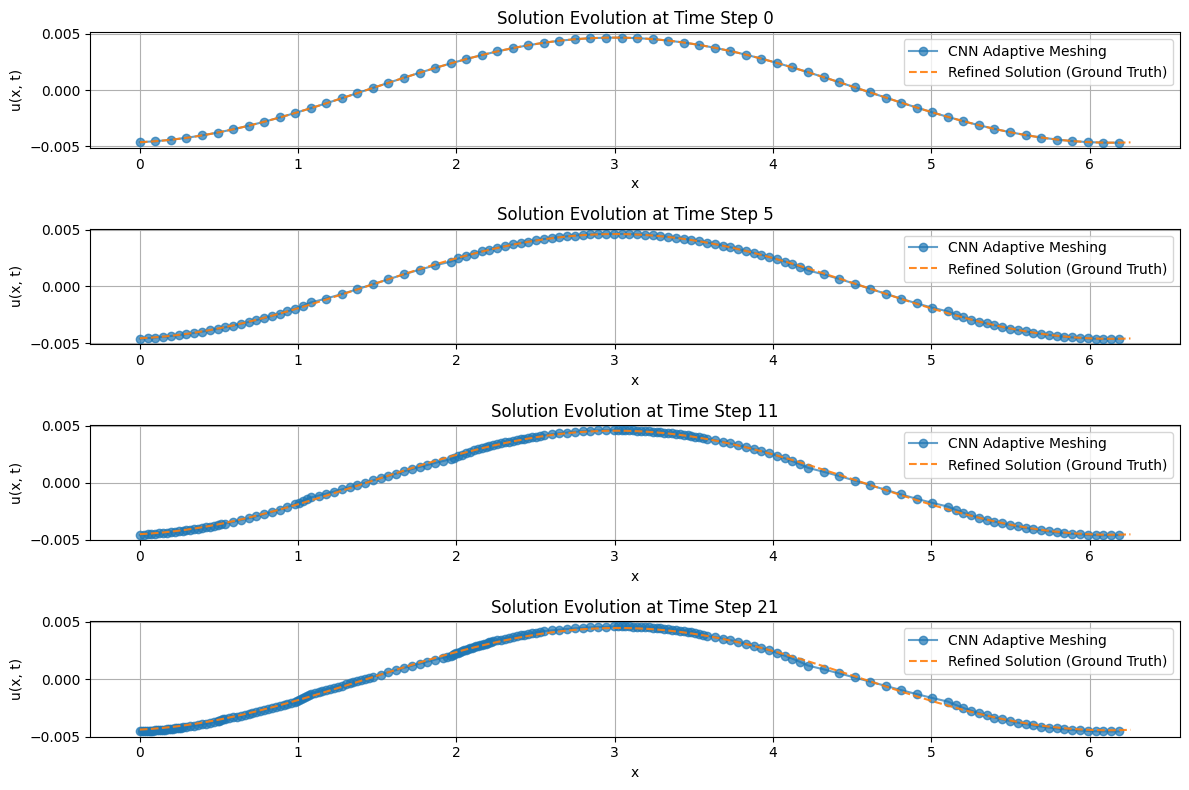

In [8]:
# Solve using the neural network for adaptive meshing

x_nn_history, u_nn_history = solve_burgers_with_nn(Q, 'uniform', nu, L, N, M, T, adaptive_mesh_model, max_len, u_init_ref, x_ref)


# Solve using the spectral method to get the refined solution
x_refined, u_refined_history = compute_spectral_refined(Q, nu, L, T, 256, u_init_ref)

# Time steps to visualize
time_steps_to_plot = [0, len(u_nn_history) // 4, len(u_nn_history) // 2, len(u_nn_history) - 1]

# Plot the solution at selected time steps
plt.figure(figsize=(12, 8))
for i, step in enumerate(time_steps_to_plot):
    plt.subplot(len(time_steps_to_plot), 1, i + 1)

    # Neural network solution
    plt.plot(x_nn_history[step], u_nn_history[step], label='CNN Adaptive Meshing', marker='o', linestyle='-', alpha=0.7)

    # Refined solution
    plt.plot(x_refined, u_refined_history[step], label='Refined Solution (Ground Truth)', linestyle='--', alpha=0.9)

    # Add labels and title
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.title(f'Solution Evolution at Time Step {step}')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
